# Electricity Tariff in Norway

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from utils import *
from latexify import *

## Time-of-use prices

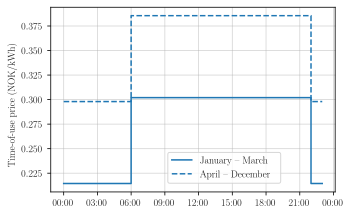

In [2]:
def create_monthly_price_data(year, month, peak_price, off_peak_price):
    date_range = pd.date_range(start=f'{year}-{month:02d}-01', periods=pd.Timestamp(year, month, 1).days_in_month * 24, freq='H', tz=None)
    prices = [off_peak_price if (hour < 6 or hour >= 22) else peak_price for hour in date_range.hour]
    return pd.Series(prices, index=date_range)

def get_peak_and_off_peak_prices(month):
    return (0.3020, 0.2145) if month in [1, 2, 3] else (0.3855, 0.2980)

price_data = pd.concat([
    create_monthly_price_data(year, month, *get_peak_and_off_peak_prices(month))
    for year in range(2020, 2024)
    for month in range(1, 13)
])

# Save as CSV
price_data = pd.DataFrame({"TOU Price (NOK/kWh)": price_data})
price_data.to_csv("data/tou_prices.csv", header=True)

# Plot time-of-use tariff
latexify(fig_width=5)
fig, ax = plt.subplots()
jan_data = price_data.loc['2020-01-01':'2020-01-01']
jun_data = price_data.loc['2020-06-01':'2020-06-01']
ax.step(jan_data.index, jan_data.values, where='post', color="tab:blue", linestyle="solid", label='January -- March')
ax.step(jan_data.index, jun_data.values, where='post', color="tab:blue", linestyle="dashed", label='April -- December')
ax.set_ylabel("Time-of-use price (NOK/kWh)")
ax.legend(bbox_to_anchor=(0.61, 0.02), loc='lower center')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.tight_layout()

plt.savefig("figures/tou_tariff.pdf")

## Day-ahead spot prices

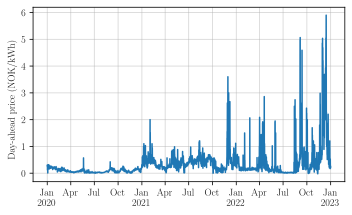

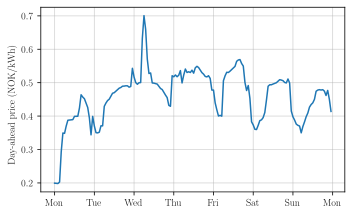

In [3]:
spot_price_data = pd.read_csv('data/spot_prices.csv', parse_dates=[0], index_col=0)["Spot Price (NOK/kWh)"]
spot_price_data = spot_price_data[spot_price_data.index.year <= 2022]

class JanYearDateFormatter(mdates.DateFormatter):
    def __init__(self, fmt='%b'):
        super().__init__(fmt)

    def __call__(self, x, pos=0):
        dt = mdates.num2date(x)
        if dt.month == 1:
            return dt.strftime('%b\n%Y')
        else:
            return dt.strftime('%b')

# Plot spot price data (2020-2022)
latexify(fig_width=5)
fig, ax = plt.subplots()
plt.plot(spot_price_data, color="tab:blue")
plt.ylabel("Day-ahead price (NOK/kWh)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(JanYearDateFormatter())
plt.xticks(rotation=0, ha='center')
plt.tight_layout()

plt.savefig("figures/spot_prices_three_years.pdf")
    
# Plot spot prices for one week in January 2022
latexify(fig_width=5)
fig, ax = plt.subplots()
week_data = spot_price_data.loc['2022-01-03':'2022-01-09']
ax.plot(week_data.values, color="tab:blue")
ax.set_ylabel("Day-ahead price (NOK/kWh)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])
plt.tight_layout()

plt.savefig("figures/spot_prices_one_week.pdf")

## Peak power cost

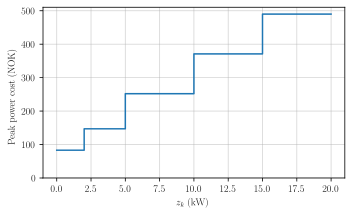

In [4]:
# Define parameters
peak_power_staircase = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20)]
peak_cost_staircase = [83, 147, 252, 371, 490]

peak_power_values = np.linspace(0, 20, 500)

# Compute peak cost for tiered peak pricing
peak_price_values, peak_cost_tiered = [], []
for (x_min, x_max), price in zip(peak_power_staircase, peak_cost_staircase):
    x_range = np.linspace(x_min, x_max, 100)
    peak_price_values.extend(x_range)
    peak_cost_tiered.extend([price] * len(x_range))

# Create plot
latexify(fig_width=5)
fig, ax = plt.subplots()
ax.plot(peak_price_values, peak_cost_tiered, color="tab:blue")
ax.set_xlabel("$z_k$ (kW)")
# ax.set_xlabel("Average of the top 3 daily maximum power usages within a month (kW)")
ax.set_ylabel("Peak power cost (NOK)")
ax.set_ylim(0)
plt.tight_layout()

plt.savefig("figures/peak_power_tariff.pdf")